# Testing

In [2]:
import numpy as np
import xarray as xr
import random
import matplotlib.pyplot as plt

from cmethods.CMethods import CMethods
cm = CMethods()

np.random.seed(0)
random.seed(0)

In [148]:
obsh = xr.open_dataset('input_data/obs.nc')
simh = xr.open_dataset('input_data/contr.nc')
simp = xr.open_dataset('input_data/scen.nc')

In [177]:
def qm(ref,contr,scen,n_quantiles = 100,detrended=False):
    obs, simh, simp = np.array(ref), np.array(contr), np.array(scen)
    
    global_max = max(np.amax(obs), np.amax(simh))
    global_min = min(np.amin(obs), np.amin(simh)) 
    wide = abs(global_max - global_min) / n_quantiles 
    xbins = np.arange(global_min, global_max + wide, wide)

    cdf_obs = cm.get_cdf(obs, xbins)
    cdf_simh = cm.get_cdf(simh, xbins)
    res = scen.copy(deep=True)
    
    if detrended:    
        for month, idxs in scen.groupby('time.month').groups.items():
            m_simh, m_simp = [], []
            for idx in idxs:
                m_simh.append(simh[idx])
                m_simp.append(simp[idx])
            
            m_simh_mean = np.nanmean(m_simh)     
            m_simp_mean = np.nanmean(m_simp) 

            epsilon = np.interp(m_simp - m_simp_mean + m_simh_mean, xbins, cdf_simh)
            x = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins) + m_simp_mean - m_simh_mean
            for i, idx in enumerate(idxs): res.values[idx] = x[i]
        return res
    else:    
        epsilon = np.interp(simp, xbins, cdf_simh)                                 # Eq. 1            
        res.values = cm.get_inverse_of_cdf(cdf_obs, epsilon, xbins)
        return res

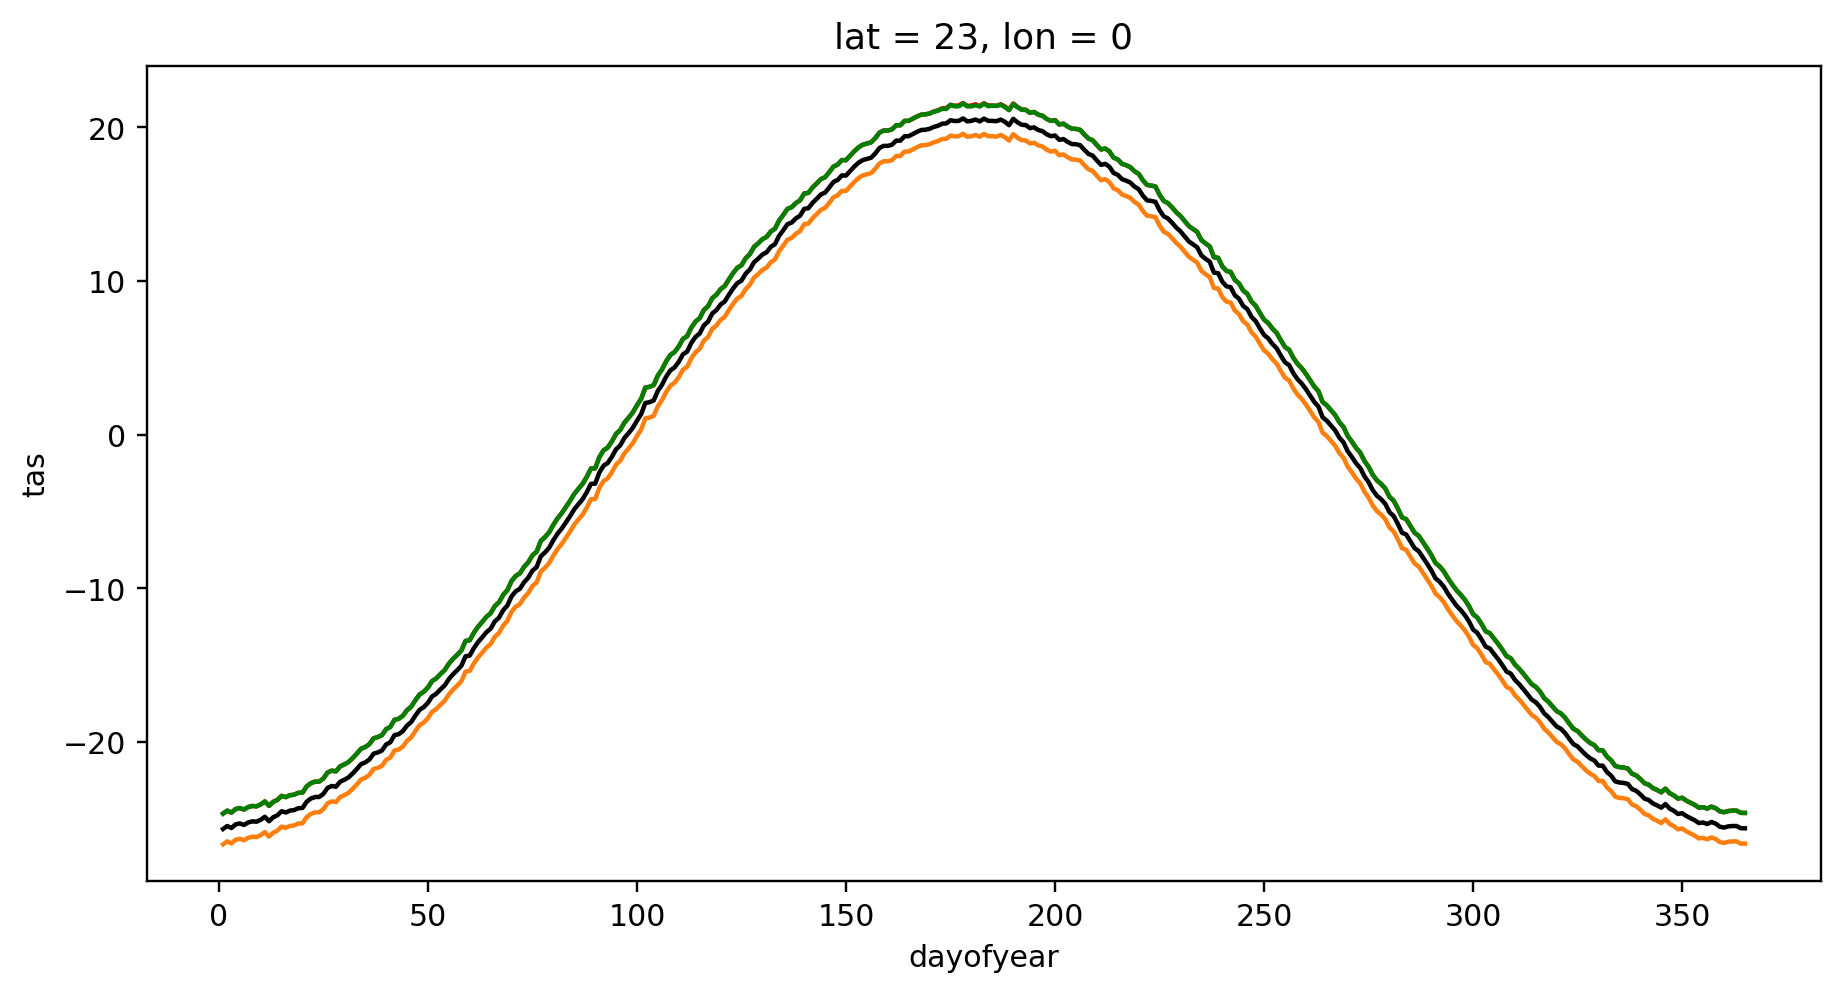

In [178]:
res = qm(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000,
    detrended=True
)
res2 = qm(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000,
    detrended=False
)
plt.figure(figsize=(10,5),dpi=216)
res.groupby('time.dayofyear').mean(...).plot(color='red')
res2.groupby('time.dayofyear').mean(...).plot(color='green')
obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='black')
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='C1')

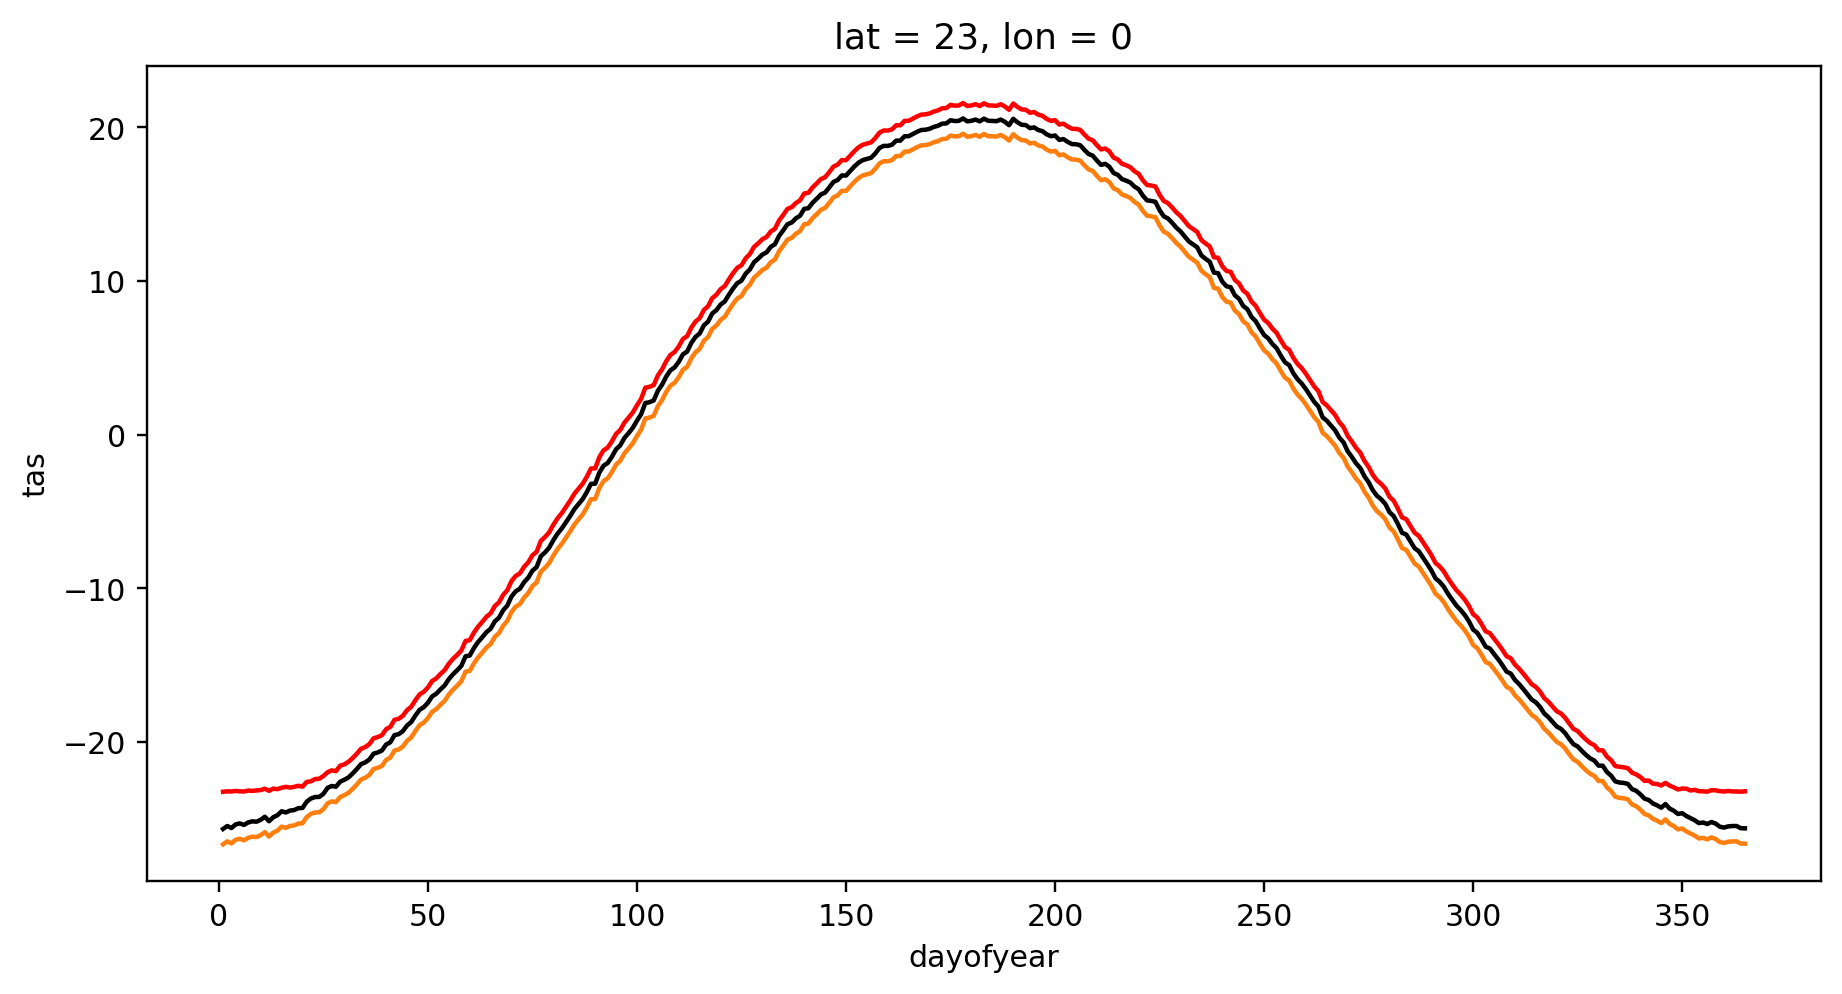

In [119]:
res = simp['tas'][:,0,0].copy(deep=True)
res.values = qm(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000,
    detrended=True
)

plt.figure(figsize=(10,5),dpi=216)
res.groupby('time.dayofyear').mean(...).plot(color='red')
obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='black')
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(color='C1')

In [111]:
# Detrended Quantile Mapping

def detrended_quantile_mapping(ref, contr, scen, n_quantiles):
    obs, simh, simp = np.array(ref), np.array(contr), np.array(scen)

    global_max = max(np.amax(obs), np.amax(simh))
    global_min = min(np.amin(obs), np.amin(simh)) 
    wide = abs(global_max - global_min) / n_quantiles 
    xbins = np.arange(global_min, global_max + wide, wide)
    
    
    mean_simp_t = np.nanmean(simp)
    mean_simh = np.nanmean(simh)
    
    #simh = simp+mean_simh
    
    
    cdf_simh = cm.get_cdf(simh,xbins)
    
    from scipy import interpolate

    #f = interpolate.interp1d(xbins, cdf_simh, fill_value = "extrapolate")
    #m = f((mean_simh * simp)/mean_simp_t)
    
    
    #print(len(m),len(xbins))
    #f = interpolate.interp1d(cm.get_cdf(obs,xbins), xbins, fill_value = "extrapolate")
    #s = f(m)
    #return s*(mean_simp_t/mean_simp)
    
    
    # OR
    m = np.interp((mean_simh * simp) / mean_simp_t, xbins, cdf_simh) # here some extrapolation is needed
    return np.interp(m, cm.get_cdf(obs,xbins), xbins)*(mean_simp_t/mean_simh)



In [112]:
res = simp['tas'][:,0,0].copy(deep=True)

In [113]:
res.values = detrended_quantile_mapping(
    ref=obsh['tas'][:,0,0],
    contr=simh['tas'][:,0,0],
    scen=simp['tas'][:,0,0],
    n_quantiles=1000
)

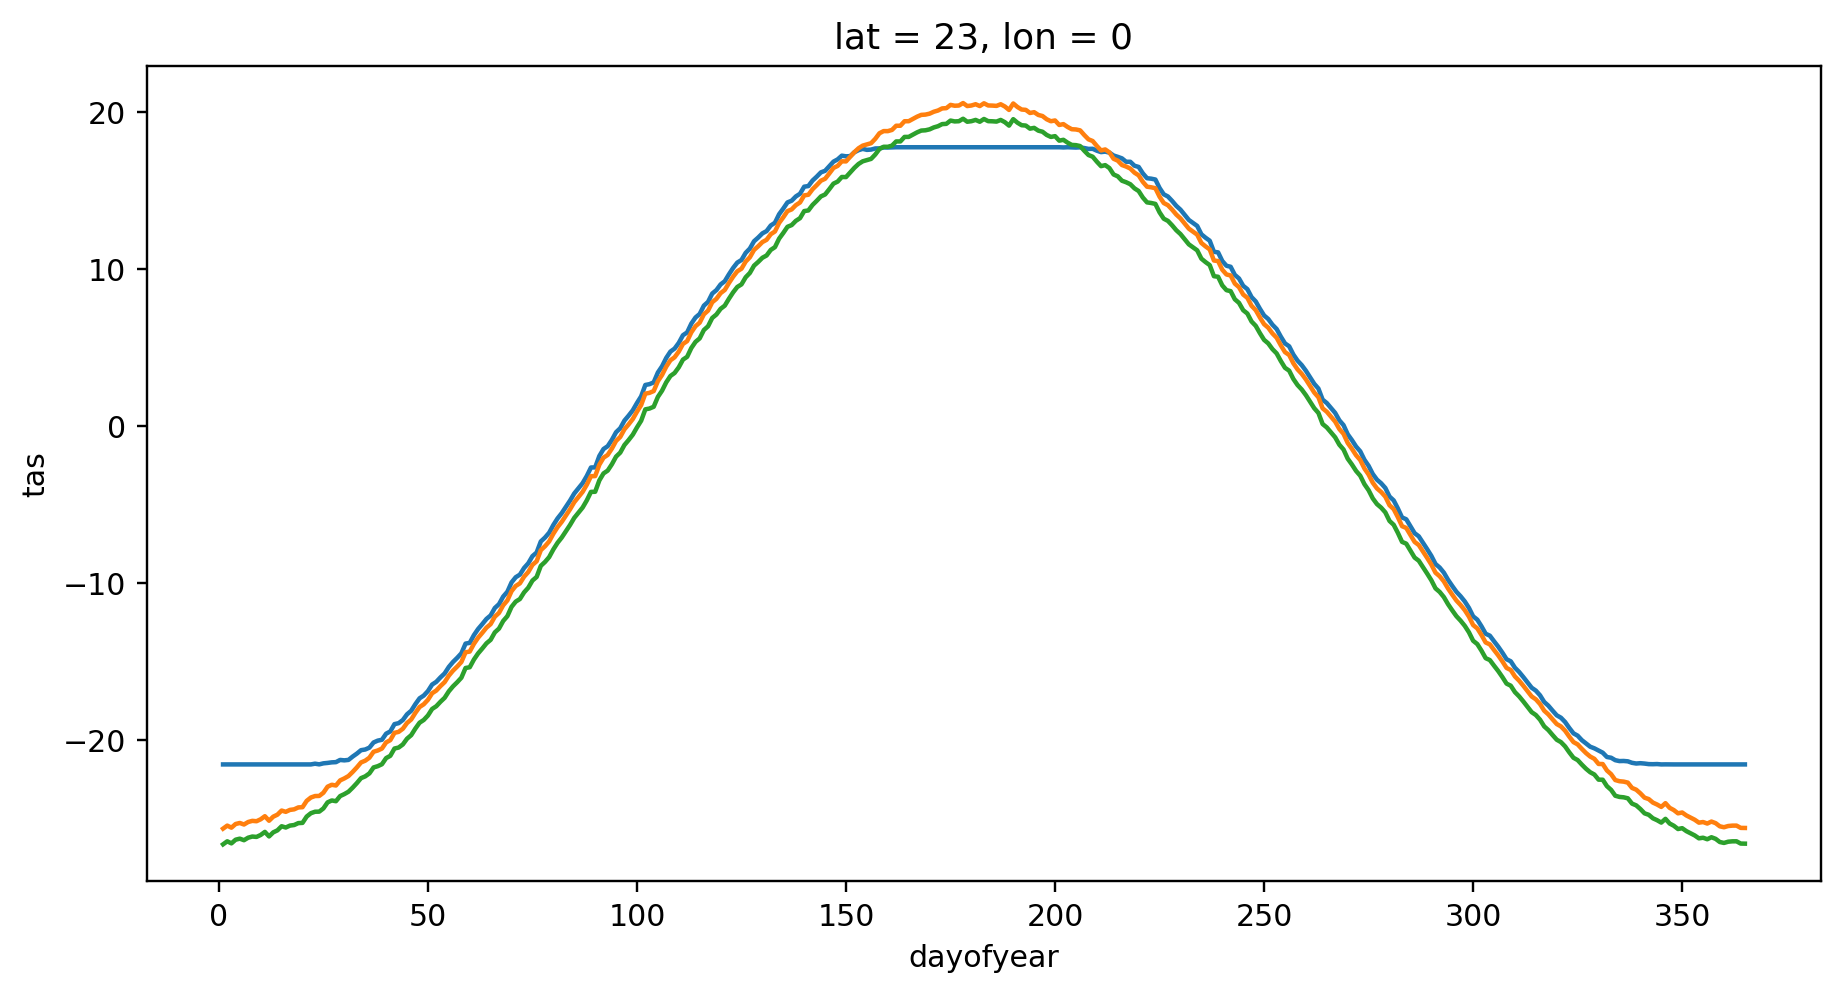

In [114]:
plt.figure(figsize=(10,5),dpi=216)
res.groupby('time.dayofyear').mean(...).plot(label='$T_{sim,h}$')
obsh['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='$T_{sim,h}$')
simp['tas'][:,0,0].groupby('time.dayofyear').mean(...).plot(label='$T_{sim,h}$')